In [1]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()  # noqa
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic
from python.cogtext.pubmed.preprocessing import PubMedPreprocessor

In [2]:
# Data and parameters
PUBMED = pd.read_csv('data/pubmed/abstracts.csv.gz').dropna(subset=['abstract']).reset_index()
train_data = PUBMED.sample(frac=0.1, random_state=0)
test_data = PUBMED.drop(train_data.index).reset_index()

train_data = train_data.pipe(PubMedPreprocessor.select_relevant_journals)
# train_data = train_data.pipe(PubMedPreprocessor.remove_short_abstracts)

test_data = test_data.pipe(PubMedPreprocessor.select_relevant_journals)
# test_data = test_data.pipe(PubMedPreprocessor.remove_short_abstracts)

In [3]:
train_data.head()

,index,pmid,doi,year,journal_title,journal_iso_abbreviation,title,abstract,category,subcategory
277307,283065,29571005,10.1016/j.jbtep.2018.03.004,2018,Journal of behavior therapy and experimental p...,J Behav Ther Exp Psychiatry,Attentional control deficits in social anxiety...,Attentional control has recently been assumed ...,CognitiveConstruct,Shifting
416679,423805,21185321,10.1016/j.neuropsychologia.2010.12.001,2011,Neuropsychologia,Neuropsychologia,Interactions between attention and visual shor...,An ever increasing amount of research in the f...,CognitiveConstruct,Attention
452837,460291,11571348,10.1212/wnl.57.6.1115,2001,Neurology,Neurology,(1)H-MR spectroscopy is sensitive to subtle ef...,The authors performed neuropsychological and (...,CognitiveConstruct,Attention
319874,326177,26431824,10.1111/tops.12156,2015,Topics in cognitive science,Top Cogn Sci,Seeing Cooperation or Competition: Ecological ...,Do cultural models facilitate particular ways ...,CognitiveConstruct,Reasoning
240136,245494,21316354,10.1016/j.brainres.2011.02.010,2011,Brain research,Brain Res,P300 as a measure of processing capacity in au...,This study examined the electrophysiological c...,CognitiveConstruct,WorkingMemory


In [4]:
X = train_data['abstract'].values
y = train_data['subcategory'].astype('category').cat.codes

# pretrained document embeddings
embeddings_file = 'models/universal-sentence-encoder-v4/abstracts_embeddings.npz'
doc_embedding_model = SentenceTransformer('all-distilroberta-v1')

# embeddings_file = 'models/all-MiniLM-L6-v2/abstracts_embeddings.npz'
doc_embeddings = np.load(embeddings_file)['arr_0']
train_doc_embeddings = doc_embeddings[train_data.index]
test_doc_embeddings = doc_embeddings[test_data.index]

# or retrain the document embedding model from scratch
# doc_embeddings = doc_embedding_model.encode(X, show_progress_bar=True)

In [5]:

# UMAP
umap_model = UMAP(
    n_neighbors=15,
    n_components=2,
    min_dist=0.0,
    metric='cosine',
    low_memory=False
)

# HDBSCAN
hdbscan_model = HDBSCAN(
    min_cluster_size=5,
    metric='euclidean',
    prediction_data=True
)

vectorizer_model = CountVectorizer(ngram_range=(1, 3), stop_words='english',
                                   min_df=10, max_df=int(X.shape[0] * 1.0))

# BERTopic
model = BERTopic(calculate_probabilities=True,
                 nr_topics='auto',
                 embedding_model=doc_embedding_model,
                 umap_model=umap_model,
                 hdbscan_model=hdbscan_model,
                 vectorizer_model=vectorizer_model,
                 verbose=True)

# fit the topic model
_, train_scores = model.fit_transform(
    documents=X, y=y, embeddings=train_doc_embeddings
)

model.save('models/BERTopic.model', save_embedding_model=False)

model.get_topic_info()

2021-11-02 13:44:31,092 - BERTopic - Reduced dimensionality with UMAP
2021-11-02 14:09:05,375 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2021-11-02 14:13:19,478 - BERTopic - Reduced number of topics from 858 to 520


,Topic,Count,Name
0,-1,10567,-1_action_object_schizophrenia_experiment
1,0,1230,0_disorder adhd_hyperactivity disorder adhd_ch...
2,1,668,1_sequencing_mutation_dna_rna
3,2,424,2_tumor_tumors_preoperative_gliomas
4,3,315,3_speech_verbal fluency_deaf_fluency tasks
...,...,...,...
497,515,5,515_dopamine_self regulation_regulation_contro...
498,516,5,516_anesthesia_noxious stimuli_thalamo_thalamo...
499,517,5,517_task significantly_computerized_diagnosed ...
500,502,5,502_biofeedback_headache_session_rtms


In [ ]:

_, test_scores = model.transform(
    documents=test_data['abstract'].values, embeddings=test_doc_embeddings
)

scores_df = pd.DataFrame(test_scores, index=test_data.index)
scores_df['label'] = test_data['subcategory']
scores_df = scores_df.groupby('label').mean()

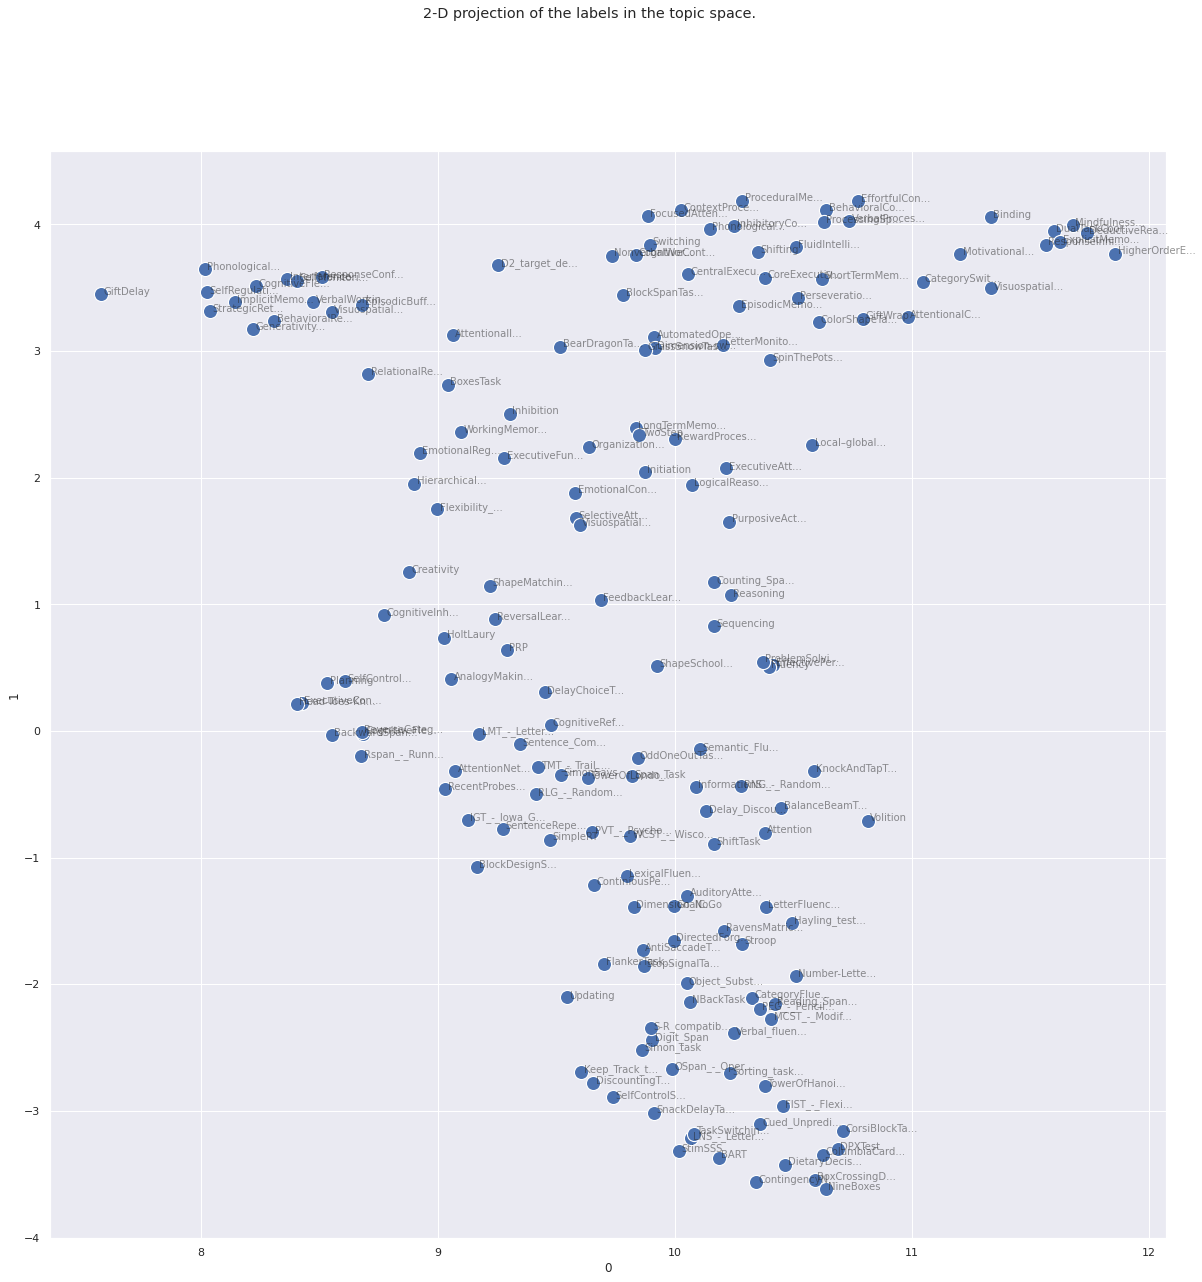

In [8]:

fig, ax = plt.subplots(1,1, figsize=(20,20))

# projected_scores = PCA(n_components=2, random_state=0).fit_transform(scores_df)
projected_scores = UMAP(n_components=2, random_state=0).fit_transform(scores_df)
projected_scores = pd.DataFrame(projected_scores, index=scores_df.index)

sns.scatterplot(data=projected_scores, x=0, y=1, ax=ax, palette='Accent', s=200)

for (lbl, x, y) in projected_scores.itertuples():
  lbl = f'{lbl[:12]}...' if len(lbl)>10 else lbl
  ax.text(x+0.01, y-np.random.random()*.01, f'{lbl}', alpha=0.5, fontsize=10)

plt.suptitle('2-D projection of the labels in the topic space.')
plt.show()
# pd.DataFrame(scores)